# Import libraries

In [48]:
import pyodbc
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from IPython.display import display

# Database connection details

In [49]:
DB = {'servername': 'RAMCO\SQLEXPRESS',
      'database': 'UnitedoutdoorsDWH'}

export_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DB['servername'] + ';DATABASE=' + DB['database'] + ';Trusted_Connection=yes')

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\ramco\AppData\Local\Temp\ipykernel_13476\3671513759.py:1: SyntaxWarning: invalid escape sequence '\S'
  DB = {'servername': 'RAMCO\SQLEXPRESS',


# Fetch relevant data from the database

In [50]:
orders_df = pd.read_sql_query("SELECT OrderKey, OrderID FROM dbo.Sales", export_conn)
order_details_df = pd.read_sql_query("SELECT OrderKey, ProductKey, EmployeeKey, Quantity, UnitPrice FROM dbo.Sales", export_conn)
display(orders_df)
display(order_details_df)

C:\Users\ramco\AppData\Local\Temp\ipykernel_13476\4285783256.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orders_df = pd.read_sql_query("SELECT OrderKey, OrderID FROM dbo.Sales", export_conn)
C:\Users\ramco\AppData\Local\Temp\ipykernel_13476\4285783256.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_details_df = pd.read_sql_query("SELECT OrderKey, ProductKey, EmployeeKey, Quantity, UnitPrice FROM dbo.Sales", export_conn)


,OrderKey,OrderID
0,1,10248
1,2,10248
2,3,10248
3,4,10249
4,5,10249
...,...,...
124570,124571,2654
124571,124572,2654
124572,124573,2003
124573,124574,2003


,OrderKey,ProductKey,EmployeeKey,Quantity,UnitPrice
0,1,525,97.0,12,14.0
1,2,556,97.0,10,9.8
2,3,586,97.0,5,34.8
3,4,528,98.0,9,18.6
4,5,565,98.0,40,42.4
...,...,...,...,...,...
124570,124571,507,21.0,3,14.0
124571,124572,508,21.0,8,9.0
124572,124573,508,68.0,12,9.0
124573,124574,510,68.0,12,7.0


# Data Preperation

In [51]:
merged_orders_df = pd.merge(orders_df, order_details_df, on='OrderKey', how='left')

merged_orders_df['TotalValue'] = merged_orders_df['UnitPrice'] * merged_orders_df['Quantity']

product_order_values = merged_orders_df[['ProductKey', 'TotalValue', 'Quantity']]

display(product_order_values)

,ProductKey,TotalValue,Quantity
0,525,168.0,12
1,556,98.0,10
2,586,174.0,5
3,528,167.4,9
4,565,1696.0,40
...,...,...,...
124570,507,42.0,3
124571,508,72.0,8
124572,508,108.0,12
124573,510,84.0,12


# Visualize the clusters

C:\Users\ramco\AppData\Local\Temp\ipykernel_13476\374019541.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  product_order_values['Cluster'] = kmeans.fit_predict(scaled_data)


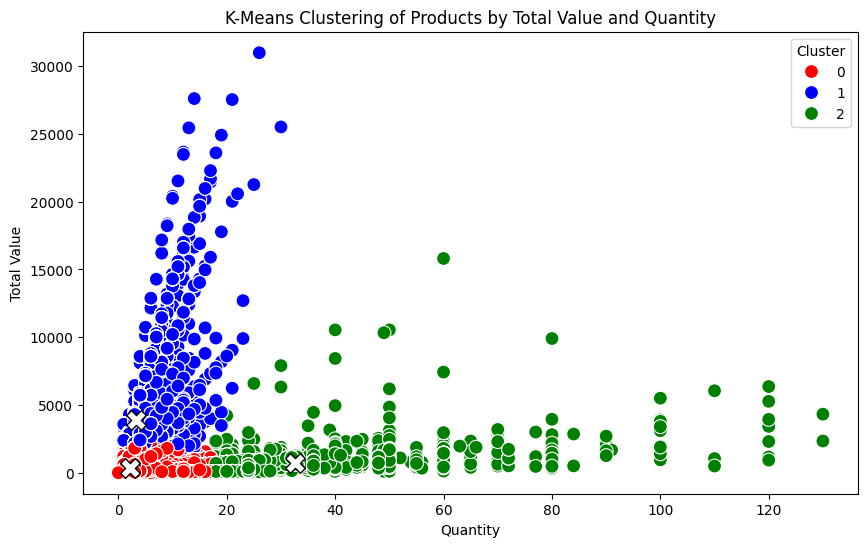

,Cluster,AvgTotalValue,AvgQuantity
0,0,341.201927,2.130448
1,1,3908.573776,3.179808
2,2,730.774009,32.603532


,ProductKey,TotalValue,Quantity,Cluster
0,525,168.0,12,0
1,556,98.0,10,0
2,586,174.0,5,0
3,528,167.4,9,0
4,565,1696.0,40,2
...,...,...,...,...
124570,507,42.0,3,0
124571,508,72.0,8,0
124572,508,108.0,12,0
124573,510,84.0,12,0


In [52]:
# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(product_order_values[['TotalValue', 'Quantity']])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
product_order_values['Cluster'] = kmeans.fit_predict(scaled_data)

# Define cluster colors
cluster_colors = {0: 'red', 1: 'blue', 2: 'green'}

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=product_order_values, x='Quantity', y='TotalValue', hue='Cluster', palette=cluster_colors, s=100)

# Calculate and plot the average values for each cluster
for cluster in product_order_values['Cluster'].unique():
    cluster_data = product_order_values[product_order_values['Cluster'] == cluster]
    avg_quantity = cluster_data['Quantity'].mean()
    avg_total_value = cluster_data['TotalValue'].mean()
    plt.scatter(avg_quantity, avg_total_value, color='white', edgecolor='black', s=200, marker='X')
    

plt.title('K-Means Clustering of Products by Total Value and Quantity')
plt.xlabel('Quantity')
plt.ylabel('Total Value')
plt.legend(title='Cluster')
plt.show()

# Calculate the average TotalValue and Quantity for each cluster
cluster_averages = product_order_values.groupby('Cluster').agg({'TotalValue': 'mean', 'Quantity': 'mean'}).reset_index()
cluster_averages.columns = ['Cluster', 'AvgTotalValue', 'AvgQuantity']

# Display the cluster averages
display(cluster_averages)

# Display the product order values with clusters
display(product_order_values[['ProductKey', 'TotalValue', 'Quantity', 'Cluster']])
